In [2]:
from GroundProjection import *
from IntersectArea import *
from ColumnProjection import *
from shapely.geometry import Polygon

from 求太阳各角度 import *
from 阳光向量 import *
from 求镜面顶点 import *
from 求镜面法向量 import *

from judge import *  # 读取距离矩阵并分析

import numpy as np
import pandas as pd


In [3]:
"函数测试"
# print(GroundProjection(np.array([1,2,3]),np.array([-1,-3,-4])))
# print(IntersectArea([[1,1],[2,1],[2,3],[1,3]],[[1,2],[1.5,1],[3,4],[2,4]]))
# vector = np.array([200,0,76])
# points = np.array([[-197.4,3,2.5],[-197.4,-3,2.5],[-202.60,-3,5.5],[-202.60,3,5.5]])
# print(ColumnProjection(vector,points)[:,[0,2]])

'函数测试'

In [4]:
"距离矩阵"

#读取数据
data = pd.read_excel('附件.xlsx')
data = np.array(data)

# 计算每个样本的欧式
def distance(P1, P2):
    return np.sqrt(np.sum((P1 - P2) ** 2))

# 创建result矩阵，用于存放每个样本之间的距离
result = np.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        if i < j:
            result[i][j] = distance(data[i,0:1], data[j,0:1])
        else:
            result[i][j] = 0
# 把上三角矩阵result转化为对称矩阵
for i in range(len(data)):
    for j in range(len(data)):
        if i > j:
            result[i][j] = result[j][i]

In [5]:
"计算镜子阴影最大影响范围"
"""
1/21  21
2/21  52
3/21  80
4/21  111
5/21  141
6/21  172
7/21  202
8/21  233
9/21  263
10/21 294
11/21 325
12/21 355
"""

min_sun_angle = 1000

phi = 39.4/180*np.pi
for day in [21,52,80,111,141,172,202,233,263,294,325,355]:
    day-=80
    for hour in [9,10.5,12,13.5,15]:
        __temp_min_sun_angle = get_alpha_s(phi,day,hour)
        if __temp_min_sun_angle < min_sun_angle:
            min_sun_angle = __temp_min_sun_angle
            print(min_sun_angle/np.pi*180,day,hour)

print(min_sun_angle/np.pi*180)

tall = 7

max_range = 7/np.tan(min_sun_angle)

max_range

17.4309154601833 -59 9
16.829321995177068 245 9
14.404529570653825 275 9
14.404529570653825


27.254254940193462

In [8]:
TC=np.array([0,0,80])
# 集热塔大小
TOWER = np.array([[3.5,-4],[3.5,4],[-3.5,4],[-3.5,-4]])

def e_mirror_rate(ID,phi,day,hour):
    '''
        
        返回 单面镜子 集热塔截断面积占比  截断效率

        ID:镜子编号
        维度phi 时间day hour  -- 太阳照射角度
        镜子中心坐标，  -- 镜子法向量&四角坐标
    '''
    mirror_center_point = np.array([data[ID][0],data[ID][1],4])
    # print(mirror_center_point)
    # 计算镜子投影位置并旋转
    sun_alpha = get_alpha_s(phi,day,hour)
    sun_vector = get_sun_vector(sun_alpha,get_gamma_s(phi,day,hour))
    mirror_column = get_mirror_out_vector(mirror_center_point)
    mirror_points = get_mirror_point(mirror_center_point,get_mirror_normal_vector(mirror_center_point,sun_vector,mirror_column),6,6)

    print(mirror_points)

    "截断效率"
    cut_rate = ColumnProjection(mirror_column,mirror_points.copy(),mirror_center_point)


    
    "阴影遮挡效率"
    shadow_area = 0
    #读取附近镜子
    max_range = 7/np.tan(sun_alpha)
    nearby = judge(result,ID,max_range)

    #获取自己的投影
    my_points = GroundProjection(mirror_points,sun_vector)
    poly1 = Polygon(my_points).convex_hull
    my_area = poly1.area
    # print(max_range)
    # print(my_points)
    for mirror in nearby:
        # 假设附近镜子朝向和自己相差无几
        mirror = data[mirror]
        mirror = np.array([mirror[0],mirror[1],4])
        m_mirror_points = get_mirror_point(mirror,get_mirror_normal_vector(mirror,sun_vector,get_mirror_out_vector(mirror)),6,6)
        o_points = GroundProjection(m_mirror_points.copy(),sun_vector)
        # print(o_points)
        # print(IntersectArea(poly1,o_points)[0])
        shadow_area += IntersectArea(poly1,o_points)[0]

    shadow_rate = 1-shadow_area/my_area

    return [cut_rate,shadow_rate]

    
    



In [18]:
print(e_mirror_rate(1500,39.4/180*np.pi,270,9))

[[235.15418162 221.77831976   6.12736772]
 [230.92642804 221.62559149   1.87263228]
 [230.70981838 227.62168024   1.87263228]
 [234.93757196 227.77440851   6.12736772]]
[1.0, 0.6466796419074078]


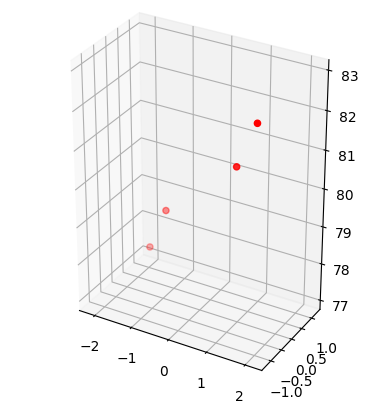

In [28]:
import matplotlib.pyplot as plt
original_points=np.array([[ 1.39583765, -0.82292483, 81.38399127],
 [-2.11626684 , 1.24765836, 77.16015629],
 [-1.39583765,  0.82292483, 78.61600873],
 [ 2.11626684 ,-1.24765836 ,82.83984371]])


o2 = np.array([[ -2.84463855 ,  0.54076367],
 [  9.70391976 ,-12.48141286],
 [  2.75757685 , -0.42878773],
 [ -3.54863472 ,  5.27300722]])

        # 画图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
        #画出原始顶点
ax.scatter(original_points[:,0],original_points[:,1],original_points[:,2],c='r')
#ax.scatter(o2[:,0],o2[:,1],c='b')
        #等比例显示
ax.set_aspect('equal')

plt.show()